# Simulations pour le nouveau modèle


### Dépendances et Fonctions

In [1]:
#coding: utf-8
import os
import sys
import logging

import pandas as pd
import numpy as np
import datetime as dt

from generate_multivariate_GP import get_time_series


# Functions, read data sets
def read_npz_dataset(train_test = "train"):
    if train_test != "train":
        train_test = "validation"
        
    
    # Read data
    data = np.load("data/data_{}.npz".format(train_test), allow_pickle = True)
    
    Xa = data["Xa"]/10000
    X_gp = data["Xgpa"]/10000
    Ya = data["Ya"]
    Ta = data["Ta"]

    # Transform data
    X_ = []; T = []; C_ = []
    for i in range(Xa.shape[0]):
        if Xa[i].ndim == 2:
            X_.append([np.array(Xa[i][b, :]) for b in range(10)])
            T.append(Ta[i])
            C_.append(Ya[i])
            
    # To numpy array
    X_ = np.array(X_, dtype = object); T = np.array(T, dtype = object)
    X_ = np.concatenate((T[:, np.newaxis], X_), axis = 1)
    C_ = np.array(C_)

    t_ = np.array([X_[i, 0].astype(int) for i in range(X_.shape[0])], dtype = object)

    return X_, t_, X_gp, C_

### Extraction des données

In [2]:
data_type = "simulated" # "real" "simulated"

# Real data
if data_type == "real":
    X_train, t_train, X_gp_train, C_train = read_npz_dataset(train_test = "train")
    X_test, t_test, X_gp_test, C_test = read_npz_dataset(train_test = "test")

# Simulated data
else:
    X_train, C_train, Ac_train, mean = get_time_series(seed = 0, n_c = 4,
                                                 p = 3, tau = 365,
                                                 n_sigc = 120)
    X_test, C_test, Ac_test, _ = get_time_series(seed = 0, n_c = 4,
                                              p = 3, tau = 365,
                                              n_sigc = 120)
    
    
CLASSES = np.unique(C_train)
nc = CLASSES.shape[0]

### M2GP Model

In [3]:
%load_ext autoreload
%autoreload 2
# Classifier
from mult_model_debug import M2GP

# Dependecies
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Ck, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic


# Kernels
Ks = [Ck(1.0, constant_value_bounds=(1e-08, 1e5)) \
        * Matern(10., length_scale_bounds=(1e-05, 1e5), nu = 2.5) \
        + WhiteKernel(noise_level=0.01,
                      noise_level_bounds=(1e-12, 1e+1)) \
        + Ck(1.0, constant_value_bounds=(1e-05, 1e5)) \
        * ExpSineSquared(),
      Ck(1.0, constant_value_bounds=(1e-08, 1e5)) \
        * Matern(10., length_scale_bounds=(1e-05, 1e5), nu = 0.5) \
        + WhiteKernel(noise_level=0.01,
                      noise_level_bounds=(1e-12, 1e+1)),
      Ck(1.0, constant_value_bounds=(1e-08, 1e5)) \
        * DotProduct(1.) \
        + RationalQuadratic(1.) \
        + WhiteKernel(noise_level=0.01,
                      noise_level_bounds=(1e-12, 1e+1))
     ]
      

# Model parameters
basis_ = "fourier"
n_basis_ = 3
tau_ = 365

In [4]:
from pickle import dump, load
train_load = "load"
models = []

if train_load == "train":
    # Fit models
    for i in range(len(Ks)):
        K = Ks[i]
        # Model definition
        model = M2GP(kernel = K, epsilon = 1e-8, base = basis_, n_basis = n_basis_, tau = tau_)
        # Fit
        model.fit(X_train, C_train)
        # Save into models
        models.append(model)
        # Save model
        with open("./models/simulated_models/model_kernel_{}.pkl".format(i), "wb") as theFile:
            dump(model, theFile)
        # Delete current model
        del(model)

else:
    # Load models
    for i in range(len(Ks)):
        # Load model
        with open("./models/simulated_models/model_kernel_{}.pkl".format(i), "rb") as theFile:
            model = load(theFile)
        # Save into models
        models.append(model)
        # Delete current model
        del(model)

In [5]:
# Print kernels
for key in models[0].kernels:
    print("Kernel {}: {}".format(CLASSES[int(key)], models[0].kernels[key]))
print()
for key in models[1].kernels:
    print("Kernel {}: {}".format(CLASSES[int(key)], models[1].kernels[key]))
print()

# Print AcAc^top True
for c in range(CLASSES.shape[0]):
    # Print AcAc^top true
    if data_type == "simulated":
        print("True Ac t(Ac) {}:\n {}".format(CLASSES[c], np.dot(Ac_train[c], Ac_train[c].T)))
        print("Predicted Ac t(Ac) {}:\n {}".format(CLASSES[c], models[0].AA_T_[c]))
        print()

Kernel 0: 0.0436**2 * Matern(length_scale=16.5, nu=2.5) + WhiteKernel(noise_level=0.028) + 1.64**2 * ExpSineSquared(length_scale=0.0456, periodicity=1)
Kernel 1: 3.34**2 * Matern(length_scale=34.6, nu=2.5) + WhiteKernel(noise_level=0.437) + 0.00516**2 * ExpSineSquared(length_scale=1e+05, periodicity=0.989)
Kernel 2: 0.744**2 * Matern(length_scale=36.3, nu=2.5) + WhiteKernel(noise_level=0.0198) + 0.364**2 * ExpSineSquared(length_scale=0.619, periodicity=0.996)
Kernel 3: 1.29**2 * Matern(length_scale=109, nu=2.5) + WhiteKernel(noise_level=0.0171) + 1.29**2 * ExpSineSquared(length_scale=0.0556, periodicity=0.5)

Kernel 0: 8.28**2 * Matern(length_scale=113, nu=0.5) + WhiteKernel(noise_level=2.62e-06)
Kernel 1: 0.742**2 * Matern(length_scale=72.1, nu=0.5) + WhiteKernel(noise_level=0.0192)
Kernel 2: 22.1**2 * Matern(length_scale=79.9, nu=0.5) + WhiteKernel(noise_level=9.36)
Kernel 3: 15**2 * Matern(length_scale=314, nu=0.5) + WhiteKernel(noise_level=5.06e-08)

True Ac t(Ac) 0:
 [[1. 0. 0.]
 

Scores du modèle et matrice de confusion

In [6]:
results = models[0].predict(X_test)

In [7]:
from sklearn.metrics import classification_report
print(classification_report(C_test, results))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       0.98      1.00      0.99       120
           2       1.00      0.98      0.99       120
           3       1.00      1.00      1.00       120

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



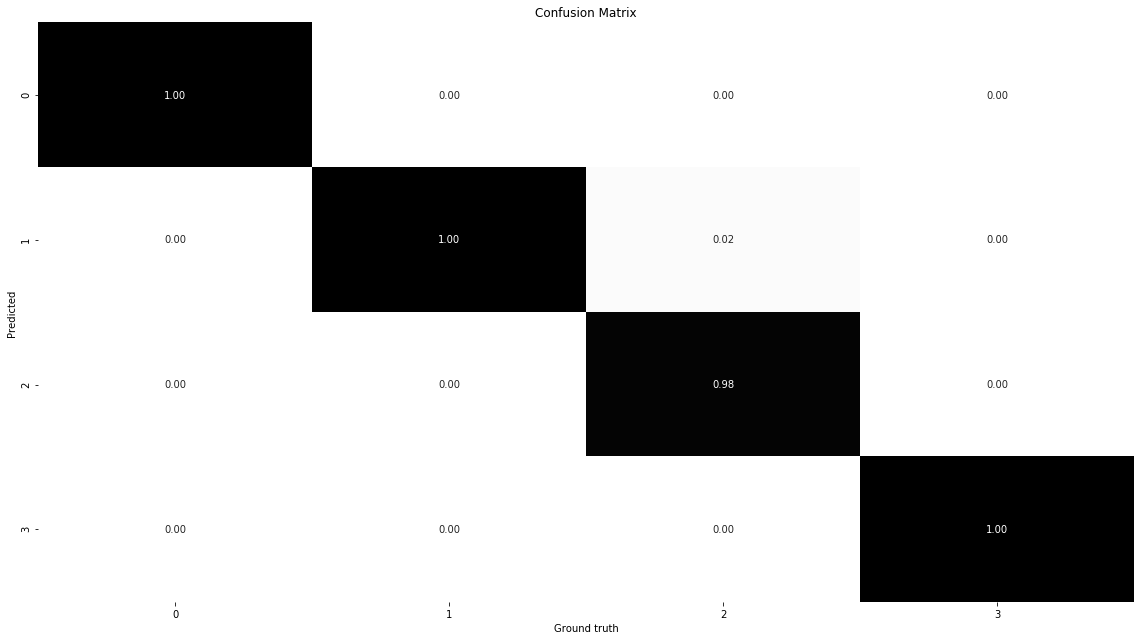

In [8]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline


from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_mat = confusion_matrix(results, C_test,
                            labels = CLASSES)
conf_mat = conf_mat / (conf_mat.sum(axis = 0)[np.newaxis, :] + 1e-6)

df_cm = pd.DataFrame(conf_mat,
                     index = [i for i in CLASSES],
                     columns = [i for i in CLASSES])
plt.figure(figsize=(16,9))
sn.heatmap(df_cm, cmap = "binary", annot=True, fmt='.2f', cbar = False)
plt.xlabel('Ground truth')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()

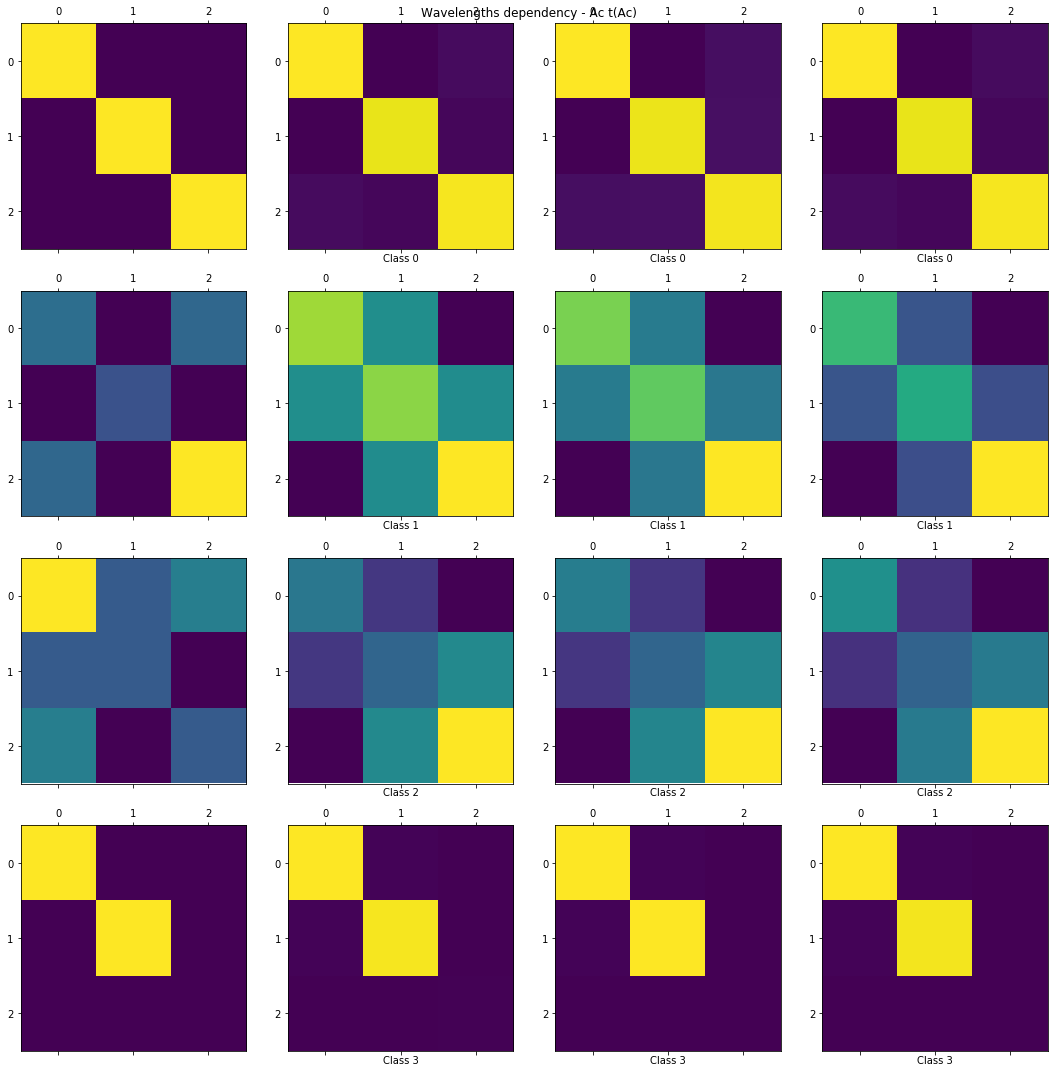

In [9]:
%matplotlib inline

# Print Ac t(Ac) for different kernels
fig = plt.figure(figsize=(15,15))
for i in range(len(Ks) + 1):
    for c in range(CLASSES.shape[0]):  
        if i == len(Ks):
            # Plot true matrix
            ax = fig.add_subplot(CLASSES.shape[0], len(Ks) + 1, c*(len(Ks)+1)+1)
            # Plot Ac t(Ac) true
            ax.matshow(np.dot(Ac_train[c], Ac_train[c].T))
        else:
            ax = fig.add_subplot(CLASSES.shape[0], len(Ks) + 1, c*(len(Ks)+1)+i+2)
            # Plot matrix for A
            ax.matshow(models[i].AA_T_[c])
        
            ax.set_xlabel("Class {}".format(CLASSES[c]))
        
fig.suptitle("Wavelengths dependency - Ac t(Ac)", y=0.99)
fig.tight_layout()

# The different kernels are on different columns
# The true matrix is on the left

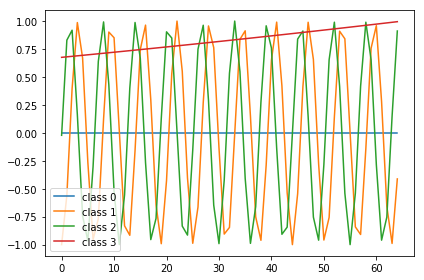

In [10]:
%matplotlib inline

plt.figure()
for c in range(CLASSES.shape[0]):
    plt.plot(mean[c][0, 300:], label = "class {}".format(c))
plt.legend()
plt.tight_layout()

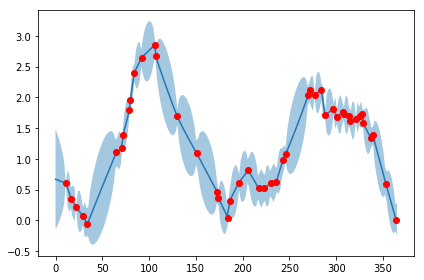

In [11]:
t_ = np.linspace(0, 365, 200).reshape(-1, 1)

i = 1
X_, std_ = models[1].input_missing_values(X_test[i], t_, c = None, return_std = True)

%matplotlib inline

b = 1
plt.figure()
plt.plot(X_[0, :], X_[b+1, :])
plt.fill_between(X_[0, :], X_[b+1, :] + 2*std_[b, :], X_[b+1, :] - 2*std_[b, :], alpha = 0.4)
plt.plot(X_test[i, 0], X_test[i, b+1], 'ro')
plt.tight_layout()

## Convergence des paramètres

In [12]:
# Select Model
i = 0

# Get parameters
iters_save_table = models[i].iters
iters_thetas = models[i].th_iters

lmls = [[-iters_save_table[c][0][it][0] \
        for it in range(len(iters_save_table[c][0]))] \
        for c in range(len(iters_save_table))]
AA_T = [[iters_save_table[c][0][it][1] \
        for it in range(len(iters_save_table[c][0]))] \
        for c in range(len(iters_save_table))]
alph = [[iters_save_table[c][0][it][2] \
        for it in range(len(iters_save_table[c][0]))] \
        for c in range(len(iters_save_table))]

np.savez('simus/params_debug/cvgce_theta_model_{}.npz'.format(i),
         thetas = np.array(iters_thetas, dtype = object),
         alphas = np.array(alph, dtype = object),
         AA_Ts  = np.array(AA_T, dtype = object),
         lmls   = np.array(lmls, dtype = object))

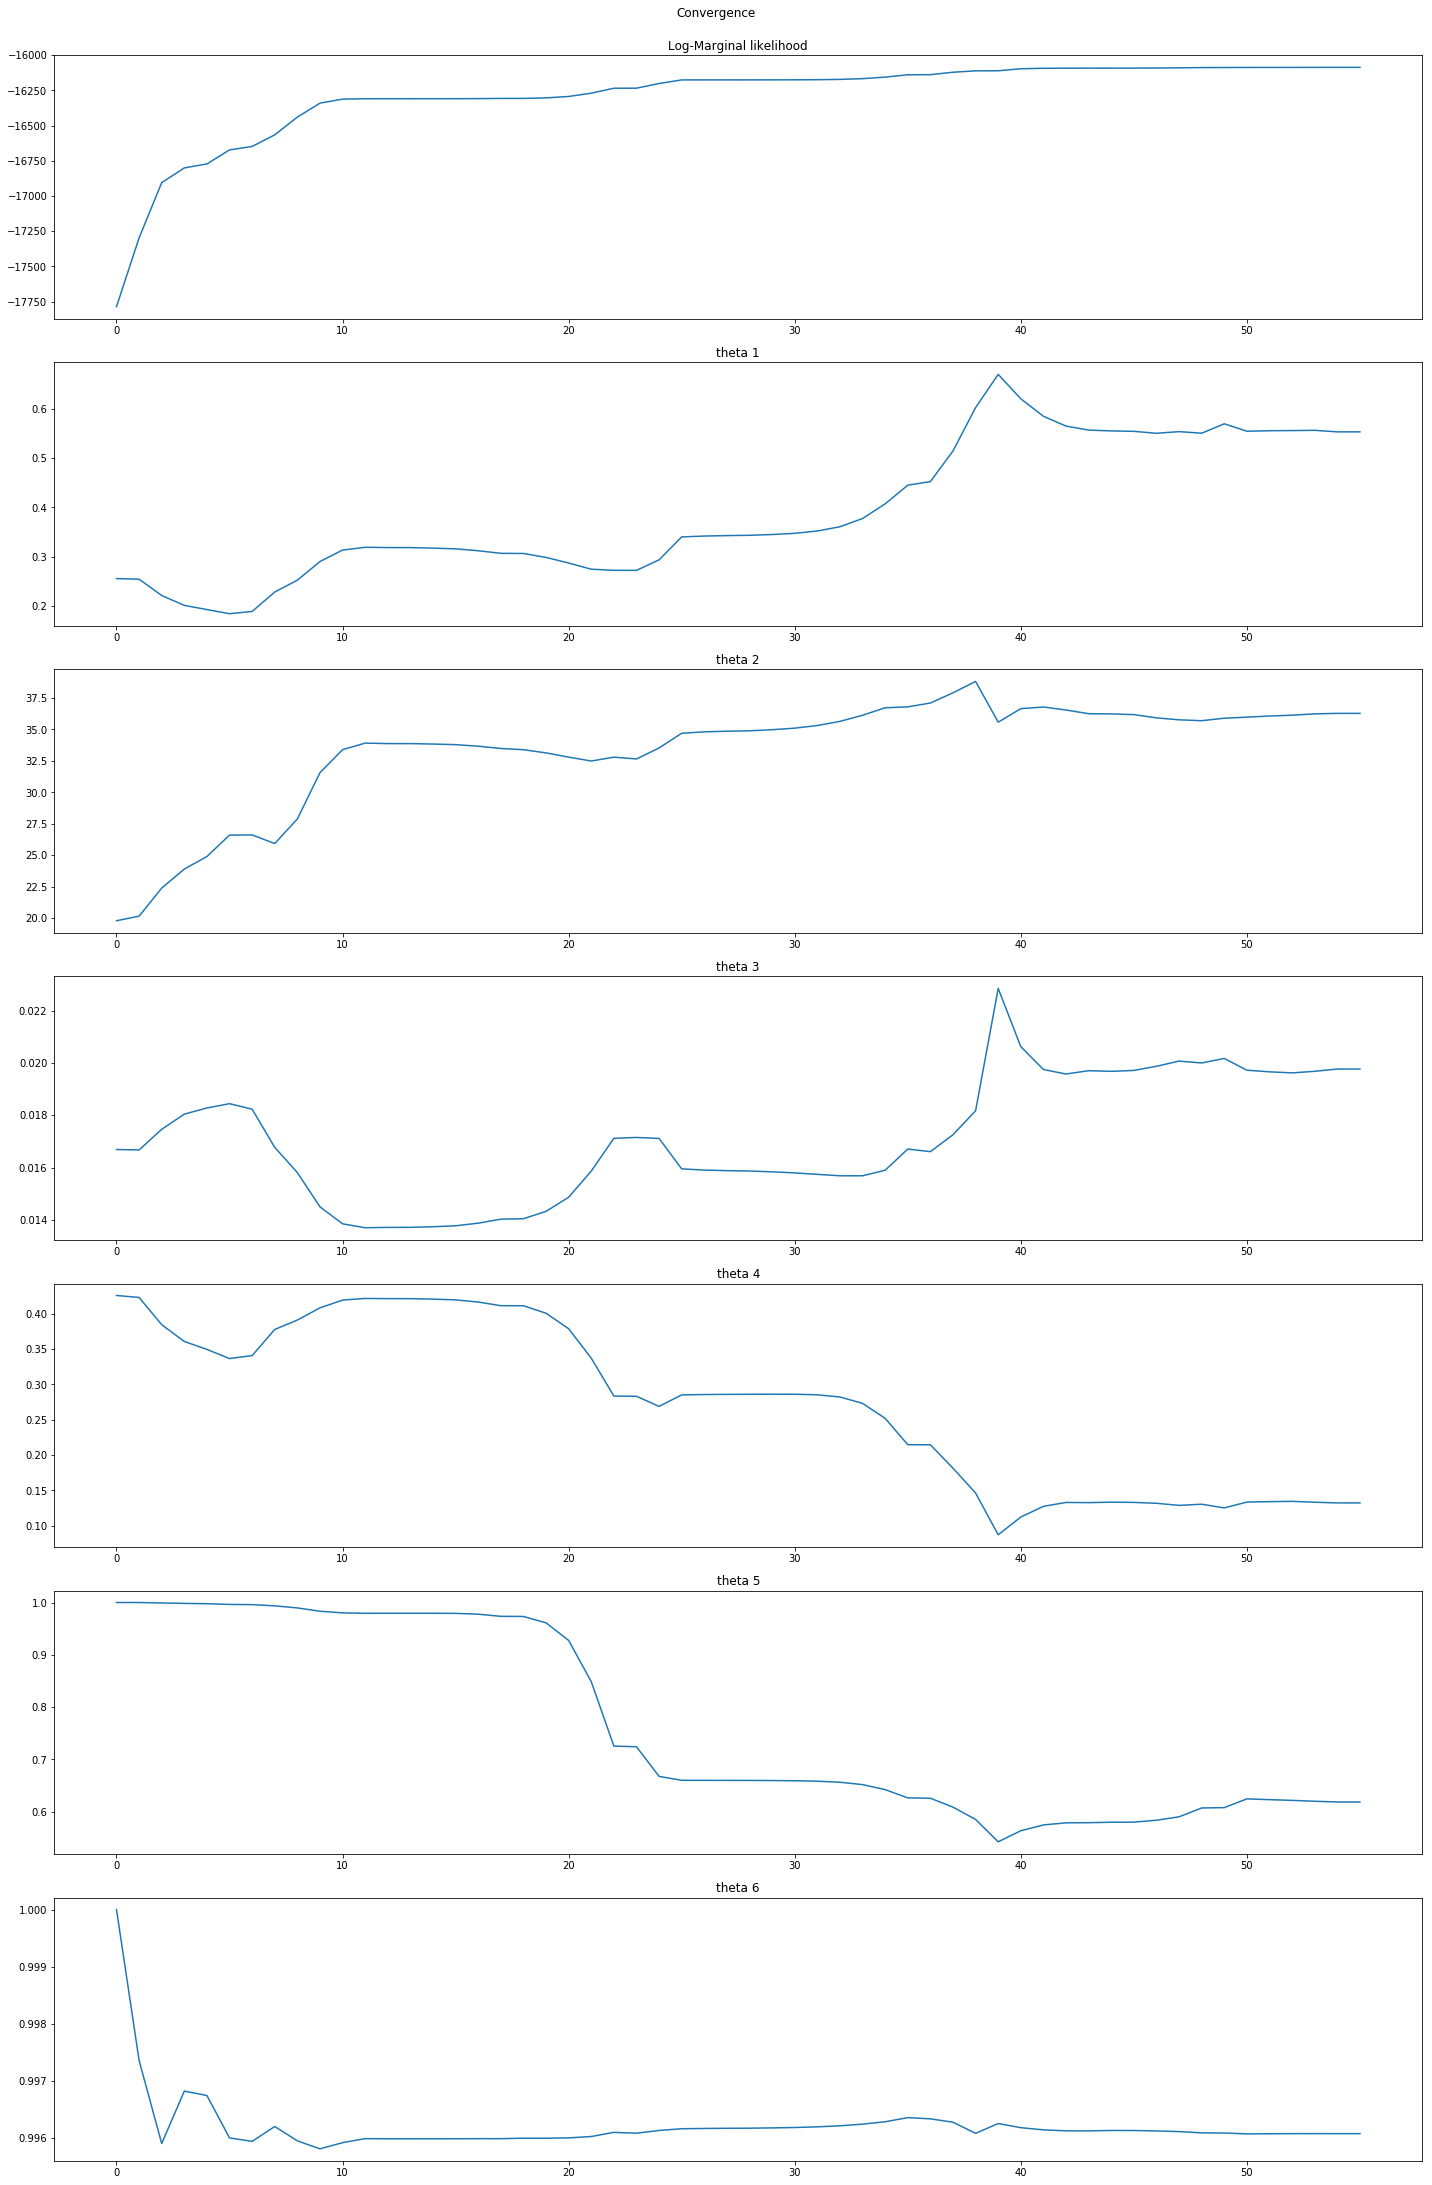

In [13]:
%matplotlib inline


# Class
c = 2
n_thetas = len(iters_thetas[c][0][0])

# Print lml for different iterations
fig = plt.figure(figsize=(20, 5*(n_thetas)))

ax = fig.add_subplot(n_thetas + 1, 1, 1)
ax.title.set_text('Log-Marginal likelihood')
ax.plot(lmls[c])
for n in range(n_thetas):
    ax = fig.add_subplot(n_thetas + 1, 1, n + 2)
    ax.title.set_text('theta {}'.format(n + 1))
    thetas_c_n = [iters_thetas[c][0][i][n] for i in range(len(iters_thetas[c][0]))]
    ax.plot(np.exp(thetas_c_n))

        
fig.suptitle("Convergence", y = 1.01)
fig.tight_layout()

In [14]:
print("Corresponding kernel:")
print()
print("{}".format(models[i].kernels["{}".format(c)]))

Corresponding kernel:

0.744**2 * Matern(length_scale=36.3, nu=2.5) + WhiteKernel(noise_level=0.0198) + 0.364**2 * ExpSineSquared(length_scale=0.619, periodicity=0.996)


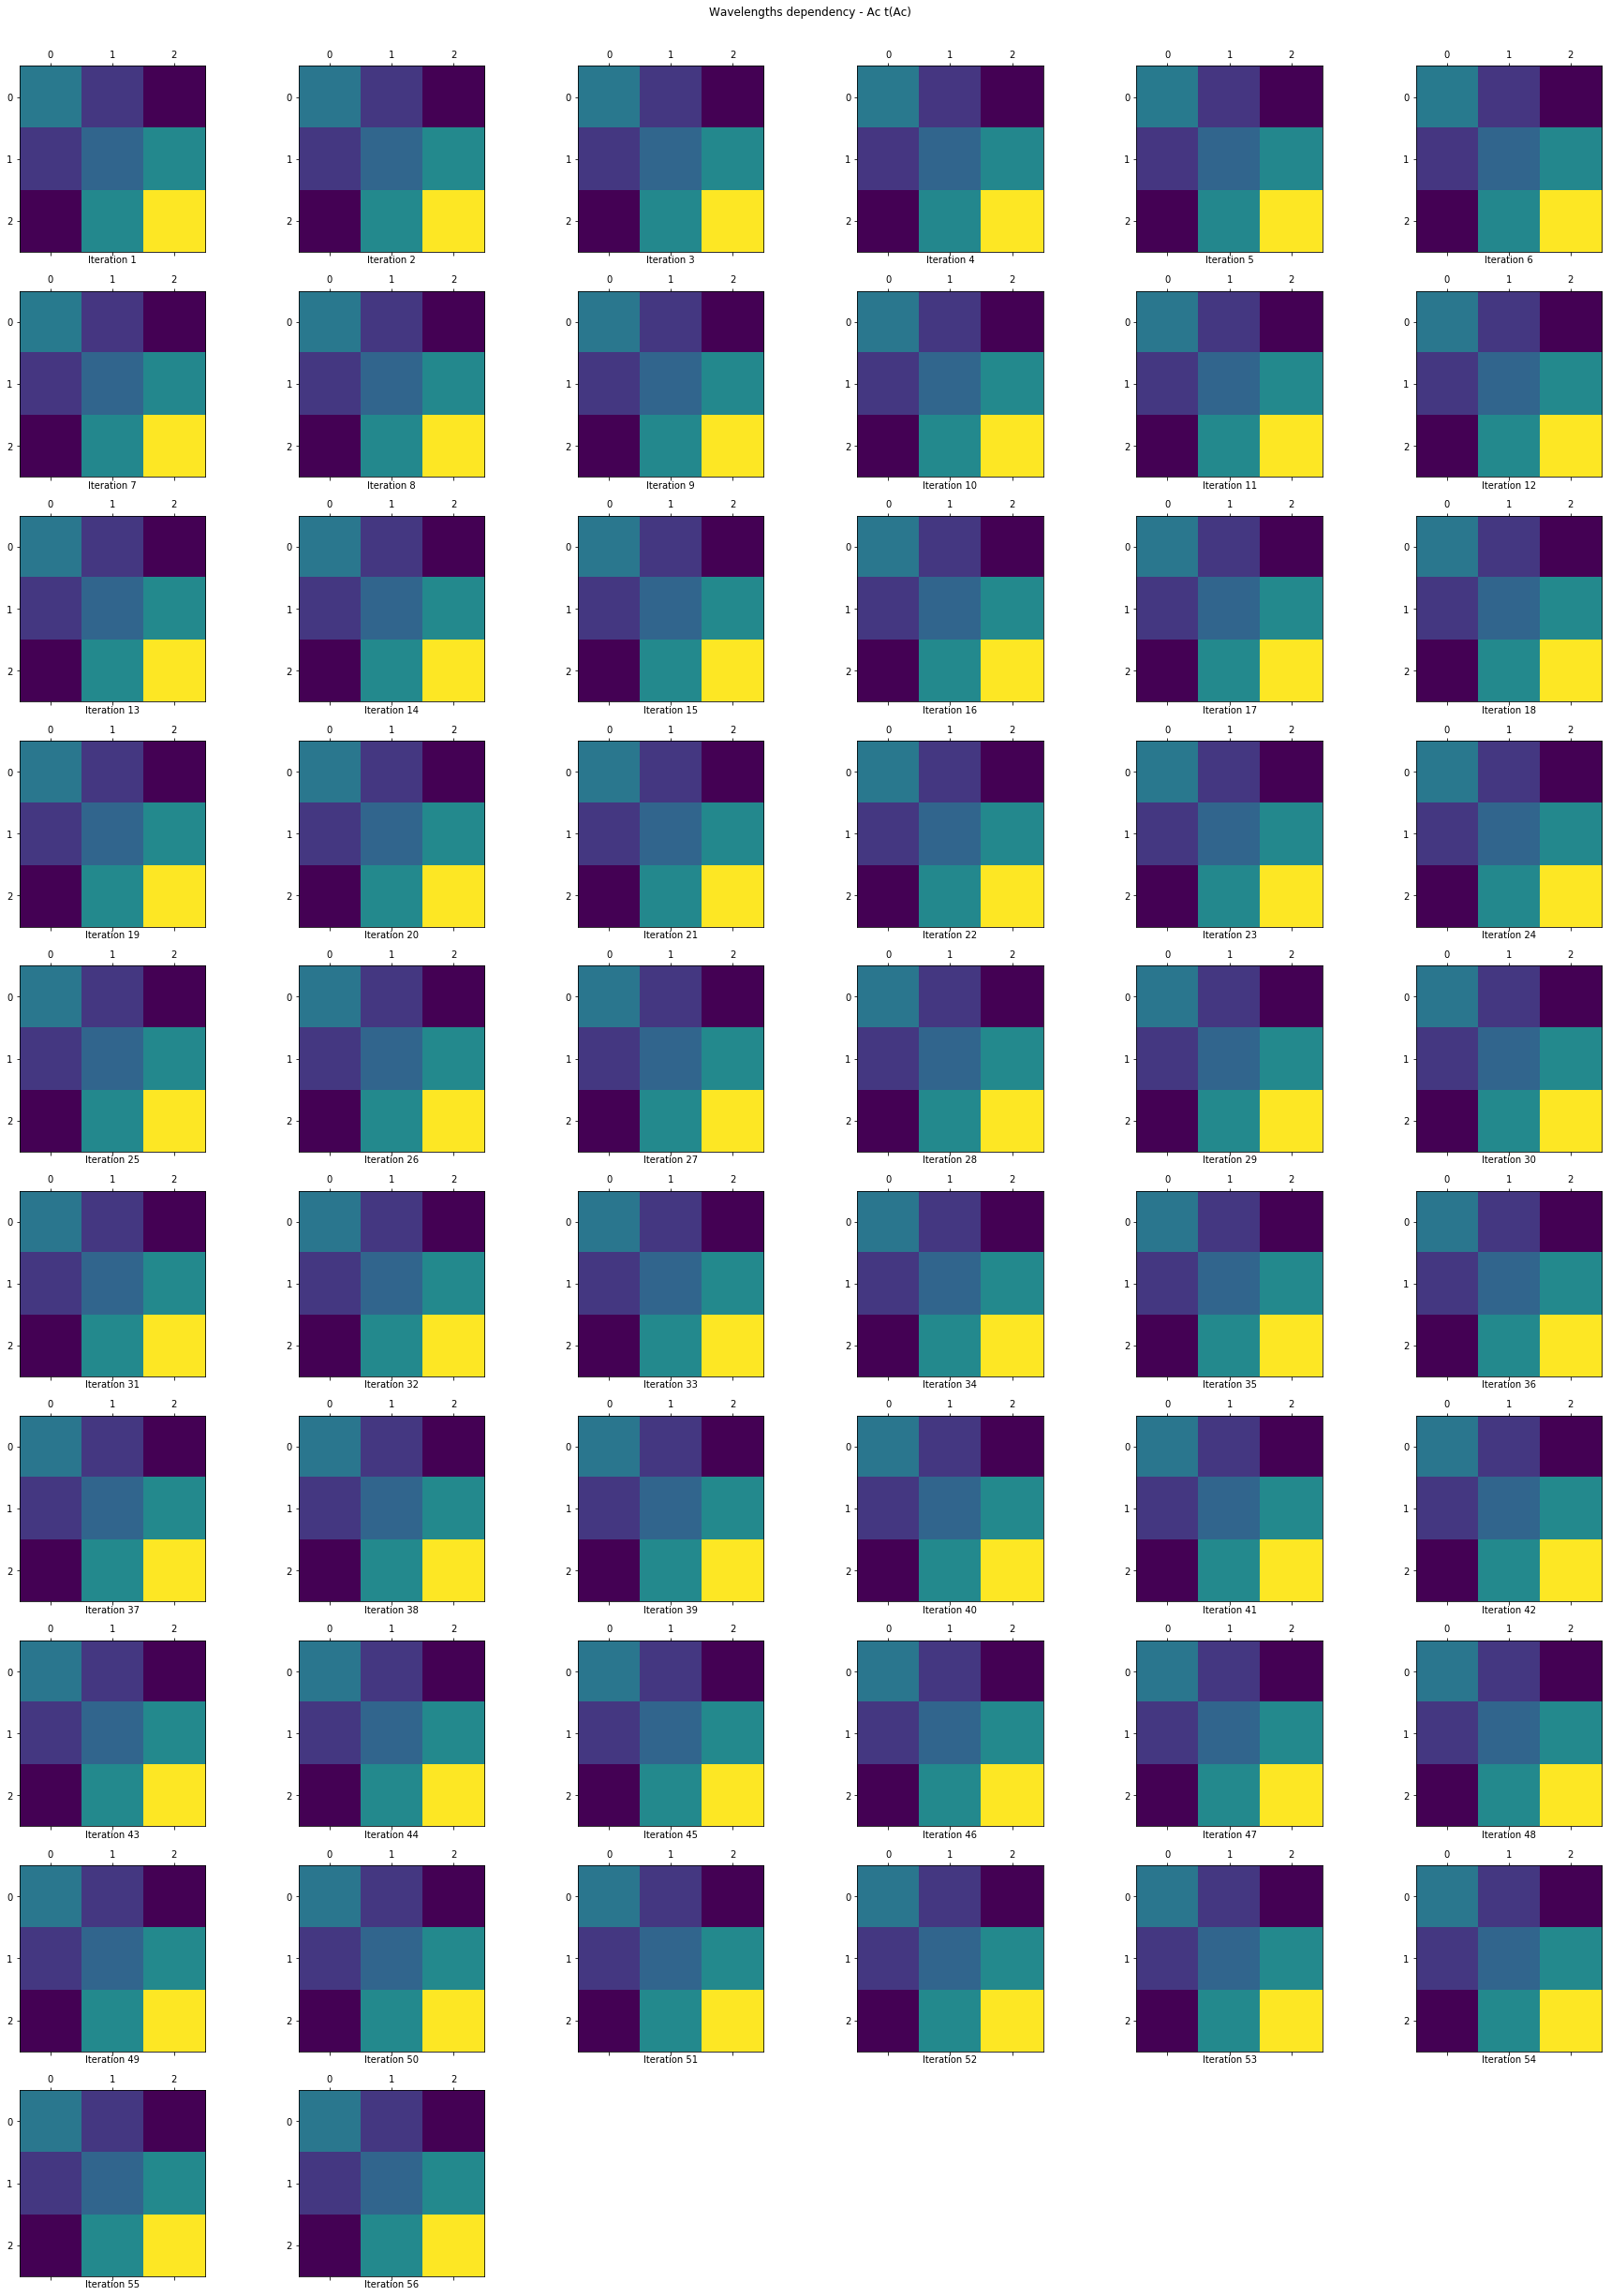

In [15]:
%matplotlib inline


# Class
c = 2

# Print Ac t(Ac) for different iterations
fig = plt.figure(figsize=(25,50))

for i in range(len(AA_T[c])):
    # Plot Ac t(Ac)
    ax = fig.add_subplot(15, 6, i + 1)
    # Plot matrix for A
    ax.matshow(AA_T[c][i])
        
    ax.set_xlabel("Iteration {}".format(i + 1))
        
fig.suptitle("Wavelengths dependency - Ac t(Ac)", y=1.01)
fig.tight_layout()

## Multiple restarts

In [16]:
# Model definition
thetas = [[1, 50, 0.01],
          [0.01, 50, 1],
          [1, 300, 0.01],
          [0.1, 1, 0.1],
          [0.1, 10, 10]]


train_load = "load"
models_iter = []

Ks = [Ck(thetas[i][0], constant_value_bounds=(1e-08, 1e5)) \
      * Matern(thetas[i][1], length_scale_bounds=(1e-05, 1e5), nu = 0.5) \
      + WhiteKernel(noise_level=thetas[i][2],
                    noise_level_bounds=(1e-12, 1e+5)) \
      for i in range(len(thetas))]

if train_load == "train":
    # Fit models
    for i in range(len(thetas)):
        K = Ks[i]
        # Model definition
        model = M2GP(kernel = K, epsilon = 1e-8, base = basis_, n_basis = n_basis_, tau = tau_)
        # Fit
        model.fit(X_train, C_train)
        # Save into models
        models_iter.append(model)
        # Save model
        with open("./models/simulated_models/model_theta0_{}.pkl".format(i), "wb") as theFile:
            dump(model, theFile)
        # Delete current model
        del(model)

else:
    # Load models
    for i in range(len(thetas)):
        # Load model
        with open("./models/simulated_models/model_theta0_{}.pkl".format(i), "rb") as theFile:
            model = load(theFile)
        # Save into models
        models_iter.append(model)
        # Delete current model
        del(model)

### Affichage des paramètres

#### Convergence des paramètres theta et de la vraisemblance

/scratch/aconstan/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


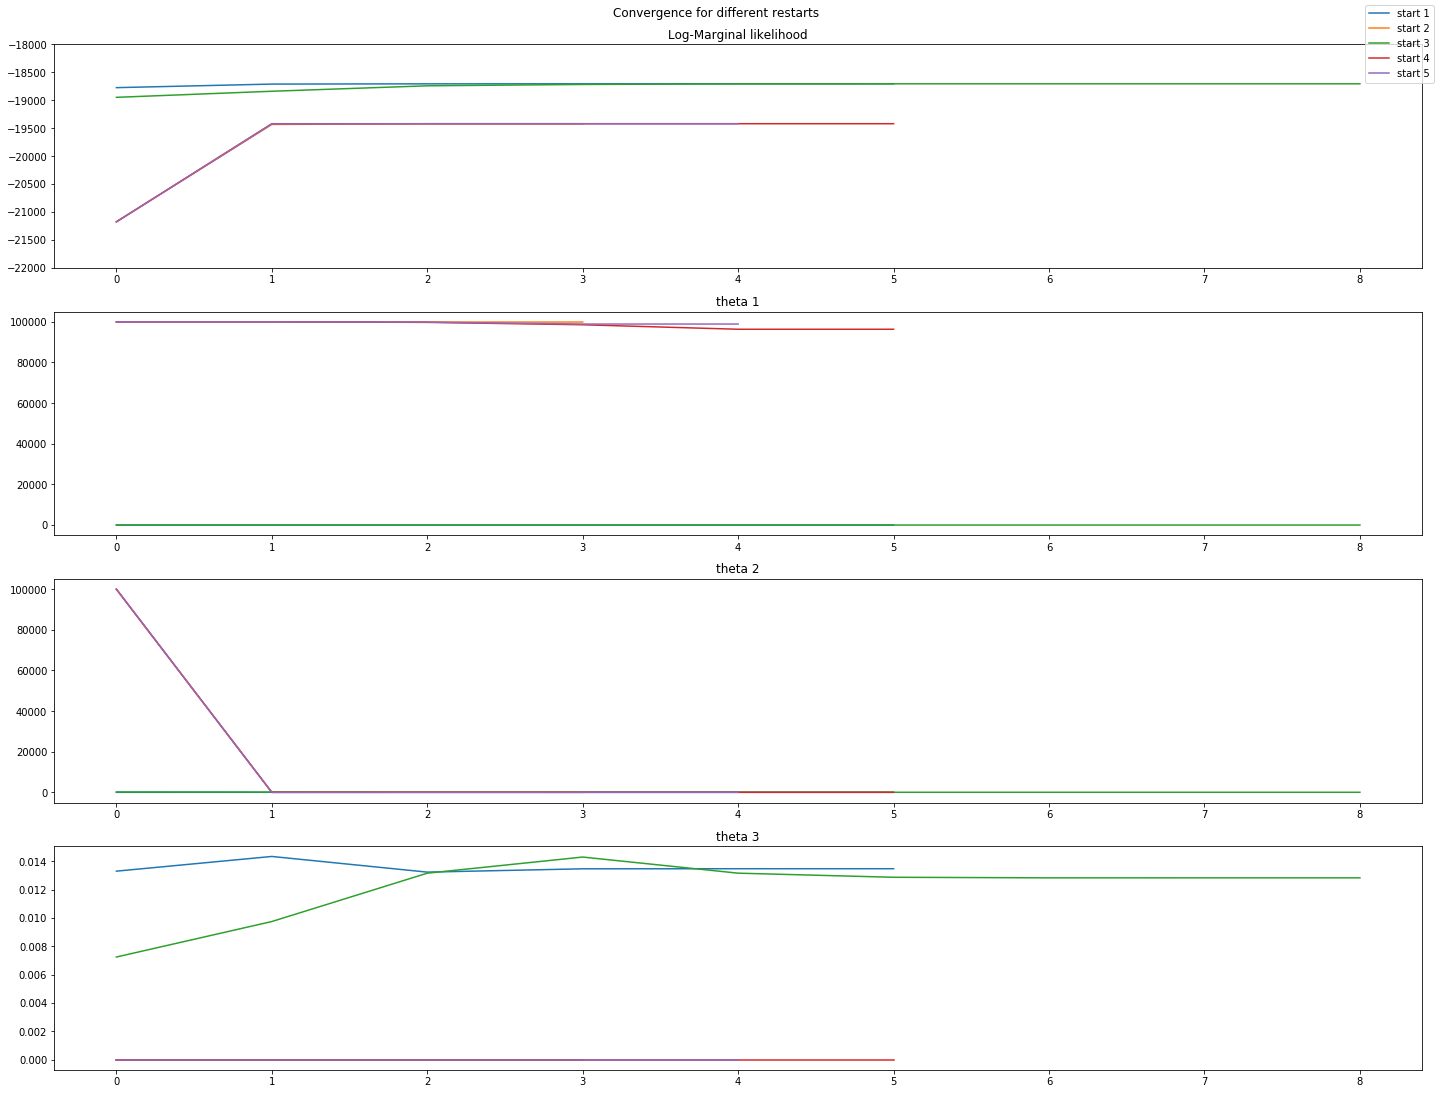

In [17]:
%matplotlib inline

n_thetas = len(thetas[0])

# Class
c = 2

fig = plt.figure(figsize=(20, 5*(n_thetas)))

for start in range(len(thetas)):
    iters_save_table = models_iter[start].iters
    iters_thetas = models_iter[start].th_iters

    lmls = [[-iters_save_table[c][0][it][0] \
            for it in range(len(iters_save_table[c][0]))] \
            for c in range(len(iters_save_table))]
    n_thetas = len(iters_thetas[c][0][0])

    # Print lml for different iterations

    ax = fig.add_subplot(n_thetas + 1, 1, 1)
    ax.title.set_text('Log-Marginal likelihood')
    ax.set_ylim(-22000, -18000)
    ax.plot(lmls[c], label = "start {}".format(start+1))
    for n in range(n_thetas):
        ax = fig.add_subplot(n_thetas + 1, 1, n + 2)
        ax.title.set_text('theta {}'.format(n + 1))
        thetas_c_n = [iters_thetas[c][0][i][n] for i in range(len(iters_thetas[c][0]))]
        ax.plot(np.exp(thetas_c_n))


fig.legend()
fig.suptitle("Convergence for different restarts", y = 1.01)
fig.tight_layout()

#### Affichage de la matrice de corrélation spectrale

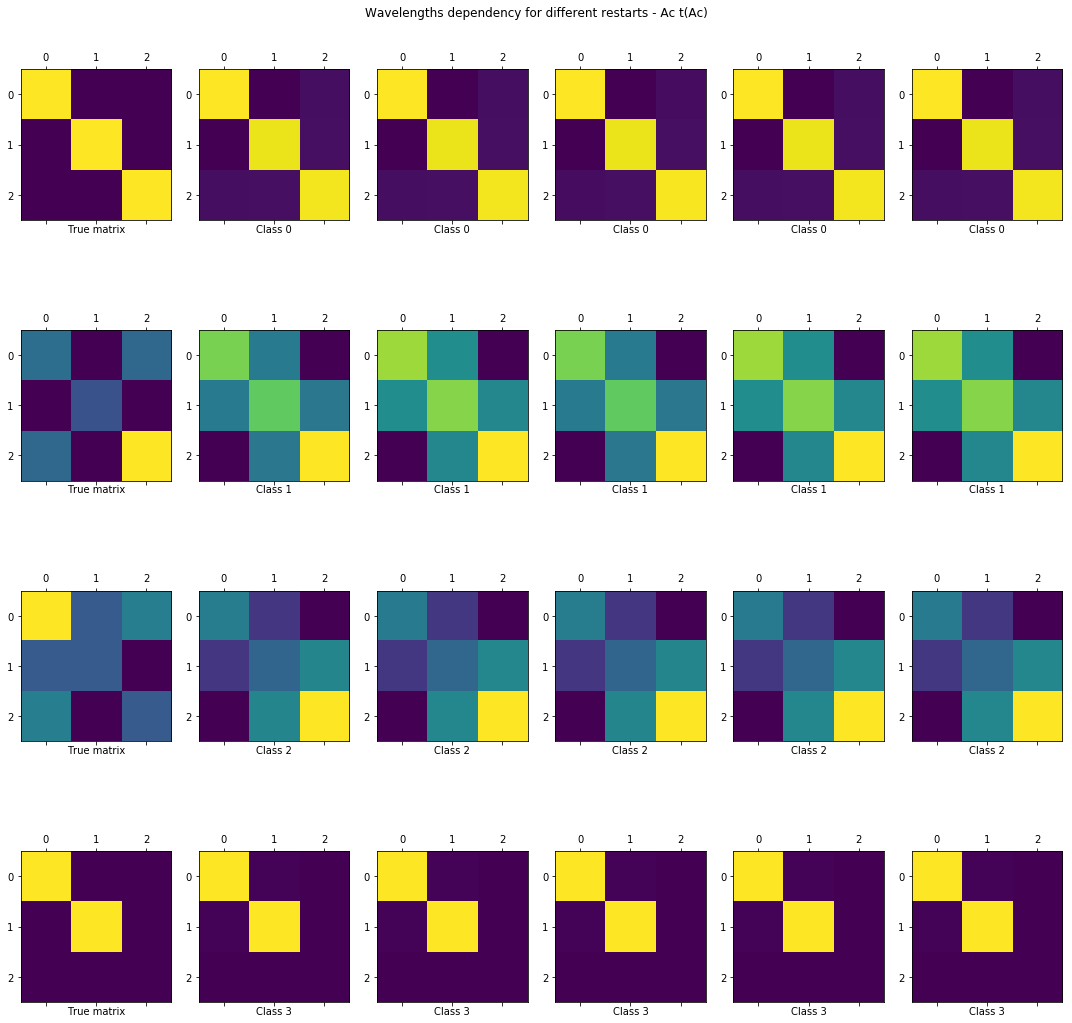

In [18]:
%matplotlib inline

# Print Ac t(Ac) for different kernels
fig = plt.figure(figsize=(15,15))
for i in range(len(Ks) + 1):
    for c in range(CLASSES.shape[0]):  
        if i == len(Ks):
            # Plot true matrix
            ax = fig.add_subplot(CLASSES.shape[0], len(Ks) + 1, c*(len(Ks)+1)+1)
            # Plot Ac t(Ac) true
            ax.matshow(np.dot(Ac_train[c], Ac_train[c].T))
            ax.set_xlabel("True matrix")
        else:
            ax = fig.add_subplot(CLASSES.shape[0], len(Ks) + 1, c*(len(Ks)+1)+i+2)
            # Plot matrix for A
            ax.matshow(models_iter[i].AA_T_[c])
        
            ax.set_xlabel("Class {}".format(CLASSES[c]))
        
fig.suptitle("Wavelengths dependency for different restarts - Ac t(Ac)", y=0.99)
fig.tight_layout()

In [19]:
# Print AcAc^top True
for c in range(CLASSES.shape[0]):
    # Print AcAc^top true
    if data_type == "simulated":
        print("Classe {}".format(CLASSES[c]))
        print("  True Ac t(Ac):\n{}".format(np.dot(Ac_train[c], Ac_train[c].T)))
        for i in range(len(Ks)):
            print("  Predicted Ac t(Ac) - start {}:\n{}".format(i + 1, models_iter[i].AA_T_[c]))
        print()

Classe 0
  True Ac t(Ac):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Predicted Ac t(Ac) - start 1:
[[ 0.0168471  -0.00046908  0.00015363]
 [-0.00046908  0.01634997  0.00026494]
 [ 0.00015363  0.00026494  0.01656102]]
  Predicted Ac t(Ac) - start 2:
[[ 1.55935935e-05 -4.33841726e-07  1.42113033e-07]
 [-4.33841726e-07  1.51336381e-05  2.45037822e-07]
 [ 1.42113033e-07  2.45037822e-07  1.53289986e-05]]
  Predicted Ac t(Ac) - start 3:
[[ 0.57490006 -0.01499261  0.0052798 ]
 [-0.01499261  0.55806815  0.00846278]
 [ 0.0052798   0.00846278  0.56863001]]
  Predicted Ac t(Ac) - start 4:
[[ 1.01984166e-05 -2.83681727e-07  9.29110005e-08]
 [-2.83681727e-07  9.89777730e-06  1.60224993e-07]
 [ 9.29110005e-08  1.60224993e-07  1.00254008e-05]]
  Predicted Ac t(Ac) - start 5:
[[ 1.01997757e-05 -2.83722330e-07  9.29233083e-08]
 [-2.83722330e-07  9.89910154e-06  1.60247851e-07]
 [ 9.29233083e-08  1.60247851e-07  1.00267350e-05]]

Classe 1
  True Ac t(Ac):
[[3.25 0.   3.  ]
 [0.   2.25 0.  ]
 [3.   0.   9.  

#### Affichage de la matrice du processus discrétisé

Affichage de la quantité
$$
AA^\top \otimes \Sigma(\theta)
$$

In [20]:
c = 2
t_ = np.linspace(0, 10, 3)

for i in range(len(Ks)):
    Sigma = models_iter[i].kernels["{}".format(c)](t_.reshape(-1, 1))
    print(np.kron(models_iter[i].AA_T_[c], Sigma))
    print()

[[15.58908576 14.36859225 13.49664416  1.64528454  1.51647269  1.42444659
  -6.65983412 -6.13842546 -5.76591935]
 [14.36859225 15.58908576 14.36859225  1.51647269  1.64528454  1.51647269
  -6.13842546 -6.65983412 -6.13842546]
 [13.49664416 14.36859225 15.58908576  1.42444659  1.51647269  1.64528454
  -5.76591935 -6.13842546 -6.65983412]
 [ 1.64528454  1.51647269  1.42444659 10.49384103  9.67226207  9.08530753
  17.2506462  15.90006657 14.93518201]
 [ 1.51647269  1.64528454  1.51647269  9.67226207 10.49384103  9.67226207
  15.90006657 17.2506462  15.90006657]
 [ 1.42444659  1.51647269  1.64528454  9.08530753  9.67226207 10.49384103
  14.93518201 15.90006657 17.2506462 ]
 [-6.65983412 -6.13842546 -5.76591935 17.2506462  15.90006657 14.93518201
  45.94704794 42.34978287 39.77981554]
 [-6.13842546 -6.65983412 -6.13842546 15.90006657 17.2506462  15.90006657
  42.34978287 45.94704794 42.34978287]
 [-5.76591935 -6.13842546 -6.65983412 14.93518201 15.90006657 17.2506462
  39.77981554 42.349782

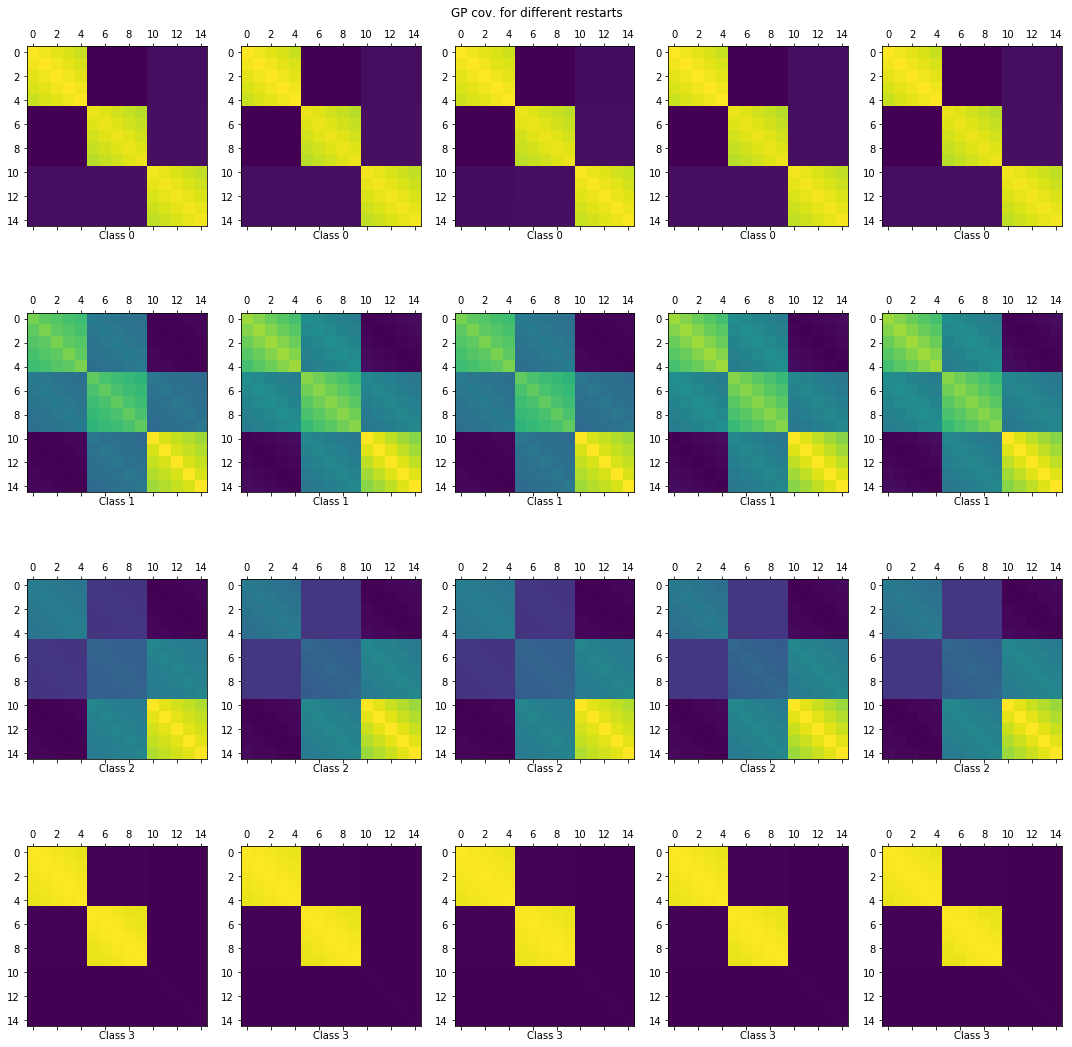

In [21]:
%matplotlib inline

t_ = np.linspace(0, 10, 5)

# Print Ac t(Ac) for different kernels
fig = plt.figure(figsize=(15,15))
for i in range(len(Ks)):
    for c in range(CLASSES.shape[0]):
        Sigma = models_iter[i].kernels["{}".format(c)](t_.reshape(-1, 1))
        ax = fig.add_subplot(CLASSES.shape[0], len(Ks), c*(len(Ks))+i+1)
        # Plot matrix for A
        ax.matshow(np.kron(models_iter[i].AA_T_[c], Sigma))
        
        ax.set_xlabel("Class {}".format(CLASSES[c]))
        
fig.suptitle("GP cov. for different restarts", y=0.99)
fig.tight_layout()